# 1. Library

In [11]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

# 2. Data Load

In [12]:
train_path = './data/train.csv'
test_path = './data/test.csv'
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
df['is_test'] = 0
df_test['is_test'] = 1
concat = pd.concat([df, df_test])     # 하나의 데이터로 만들어줍니다.

concat.columns = concat.columns.str.replace(r'[^\w]', '_', regex=True) # for lightGBM

# 3. Utils

In [13]:
def summaryBasicInfo(feature_name, value_top_n):
    print('Data nums : ', df[feature_name].shape)
    print('\n')
    print('Data values')
    print(df[feature_name].value_counts().head(value_top_n))
    print('\n')
    print('Data missing nums : ', df[feature_name].isnull().sum())
    print('Data unique nums : ', df[feature_name].nunique())


def getTargetCorr(feature_name):
    return df.corr()['target'][feature_name]

def labelEncoding(feature_name):
    lbl = LabelEncoder()
    lbl.fit( df[feature_name].astype(str) )
    df[feature_name+'_lblEncoded'] = lbl.transform(df[feature_name].astype(str))

def targetEncoding(df, feature_name):
    encoding_map = df[df['is_test'] == 0].groupby(feature_name)['target'].mean() # Target 데이터만 사용

    df.loc[df['is_test'] == 0, feature_name] = df.loc[df['is_test'] == 0, feature_name].map(encoding_map) # Train 데이터 target encoding
    df.loc[df['is_test'] == 1, feature_name] = df.loc[df['is_test'] == 1, feature_name].map(encoding_map) # Test 데이터 target encoding
    df.loc[df['is_test'] == 1, feature_name] = df.loc[df['is_test'] == 1, feature_name].fillna(df[df['is_test'] == 0]['target'].mean()) # Unseen 데이터 처리

    return encoding_map

def visualizeDistribution(feature_name, fsize=(10, 3), is_sort=False):
    count = df[feature_name].value_counts().sort_index()
    
    if is_sort == True:
        count = count.sort_values(ascending=False)

    # 거래 건수 시각화
    plt.figure(figsize=fsize)
    plt.bar(count.index.astype(str), count.values)
    plt.xlabel(feature_name)
    plt.ylabel(feature_name)
    plt.title(feature_name + '별 거래건수 분포')
    plt.xticks(rotation=45)

    feature_target = df.groupby(feature_name)['target'].mean()
    if is_sort == True:
        feature_target = feature_target.sort_values(ascending=False)

    plt.figure(figsize=fsize)

    plt.plot(feature_target.index.astype(str), feature_target.values, marker='o')
    plt.title(feature_name + '별 평균 시세 변화')
    plt.xlabel(feature_name)
    plt.ylabel('평균 시세')
    plt.xticks(rotation=45)
    
    plt.show()


# 4. Categorize data

### 범주형 변수

 - 순서형 변수 : 계약년월, 계약일, 층, 건축년도, 해제사유발생일, 등기신청일자, k-사용검사일-사용승인일, k-등록일자, k-수정일자, 단지승인일, 단지신청일

 - 명목형 변수 : 시군구, 번지, 본번, 부번, 아파트명, 도로명, 거래유형, 중개사소재지, k-단지분류(아파트,주상복합등등), k-전화번호, k-팩스번호, k-세대타입(분양형태), k-관리방식, k-복도유형, k-난방방식, k-건설사(시공사), k-시행사, k-홈페이지, 고용보험관리번호, 경비비관리형태, 세대전기계약방법, 청소비관리형태, 기타/의무/임대/임의=1/2/3/4, 사용허가여부

### 숫자형 변수

 - 이산형 변수 : k-전체동수, k-전체세대수, k-전용면적별세대현황(60㎡이하), k-전용면적별세대현황(60㎡~85㎡이하), 주차대수

 - 연속형 변수 : 전용면적(㎡), 단지소개기존clob, k-연면적, k-주거전용면적, k-관리비부과면적, k-85㎡~135㎡이하, 건축면적, 좌표X, 좌표Y, target

# 5. EDA

# 시군구
 - 총개수 : 1118822
 - 변수 타입 : 범주형 변수
 - 결측치 : 없음
 - unique : 339
 - Feature engineering
    - baseline에서는 구, 동으로 분리, 구에서 강남여부 파생변수 생성, 범주형이어서 Label Encoding 적용
    - 용산구 가격이 비싸므로 강남, 강북보다는 일단 구별로 분리할 예정
    - correlation을 구하기 위해서 Target encoding
 - Target과 상관관계
    - 구_targetEncoded : 0.541, 꽤 높은 상관관계
 - 데이터 분포
    - 강남, 서초구, 용산구가 top3 -> 구별로 상위 그룹, 중위 그룹, 하위 그룹 

In [14]:
df['구'] = df['시군구'].map(lambda x : x.split()[1])
df['동'] = df['시군구'].map(lambda x : x.split()[2])

In [25]:
gu_encoding_map = targetEncoding(df, '구')

In [ ]:
df['구'].value_counts().head(10)

In [495]:
df['구_targetEncoded'].value_counts().head(5)

33870.444730     115099
83868.032920      73785
114847.461503     69083
44215.453701      66610
54402.872801      61895
Name: 구_targetEncoded, dtype: int64

In [480]:
labelEncoding('구')
df['구'].value_counts().head(5)

8     115099
17     73785
0      69083
3      66610
1      61895
Name: 구, dtype: int64

In [494]:
getTargetCorr('구_targetEncoded') 

0.5410201815257009

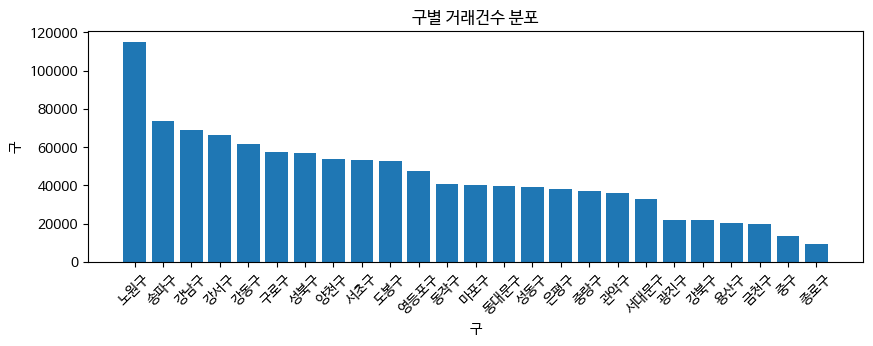

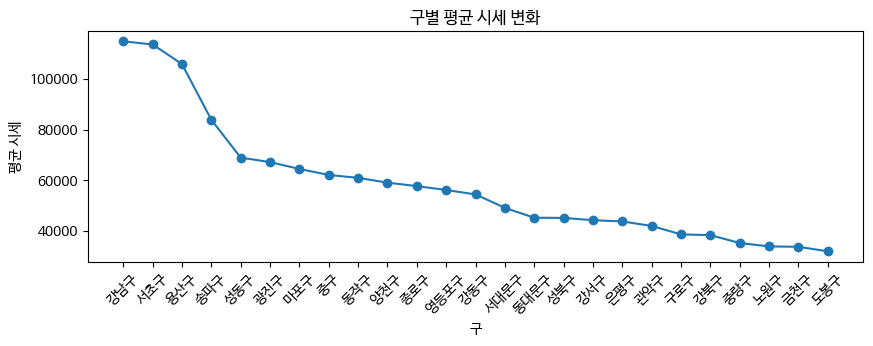

In [490]:
visualizeDistribution('구', is_sort=True)

# 계약년월
 - 총 개수 : 1118822
 - 변수 타입 : 순서형, Feature Engineering에 따라 연속형
 - 결측치 : 없음
 - unique : 198개, 범주형 변환 고려
 - Feature engineering : baseline에선 계약년, 계약월로 분리 -> 계약 년도를 10년 단위로, 월은 분기별로 파생 가능
 - Target과 상관관계
    - 계약년월 : 0.334, 약간의 상관관계 있음
    - 계약년 : 0.344, 약간의 상관관계 있음
    - 계약월 : 0.046, 상관관계 거의 없음
 - 데이터 분포
    - 2015년 거래량이 많을 때와, 2022년 거래량이 적을 때 다른 변수와 상관관계 파악하기
    - 3월에 평균 가격이 낮은 현상 파악

In [445]:
df['계약년'] = df['계약년월'].astype('str').map(lambda x : x[:4]).astype(int)
df['계약월'] = df['계약년월'].astype('str').map(lambda x : x[4:]).astype(int)

In [386]:
summaryBasicInfo('계약년월', 5)

Data nums :  (1118822,)


Data values
202006    16364
201503    15510
201808    14990
201707    14922
201705    14766
Name: 계약년월, dtype: int64


Data missing nums :  0
Data unique nums :  198


In [382]:
getTargetCorr('계약년월'), getTargetCorr('계약년'), getTargetCorr('계약월')

(0.34466514442015705, 0.34432798413420423, 0.046158376580556486)

### 계약년, 계약월별 계약 건수 시각화

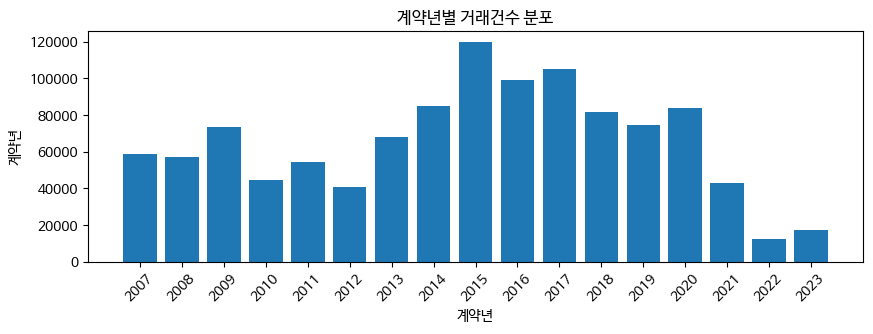

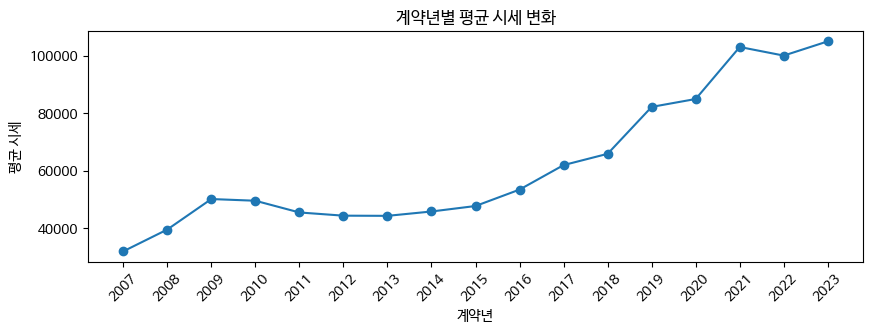

In [443]:
visualizeDistribution('계약년')

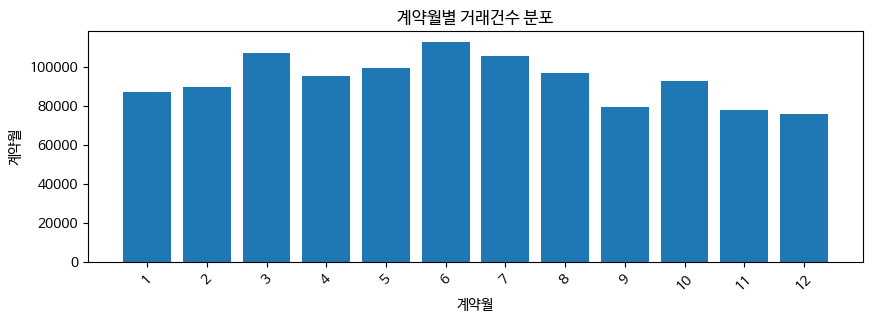

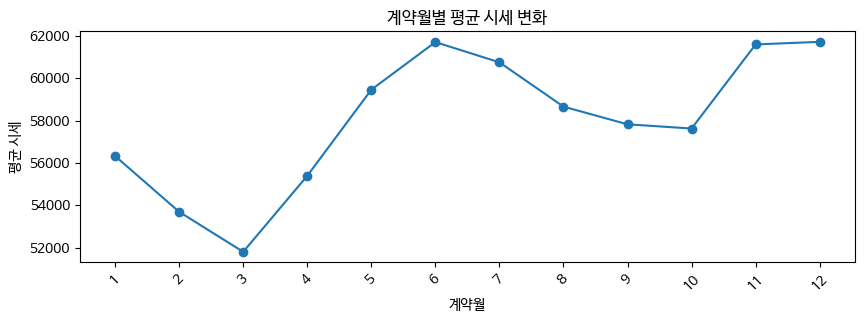

In [444]:
visualizeDistribution('계약월')

### 계약년, 계약월별 평균 Target(가격) 시각화

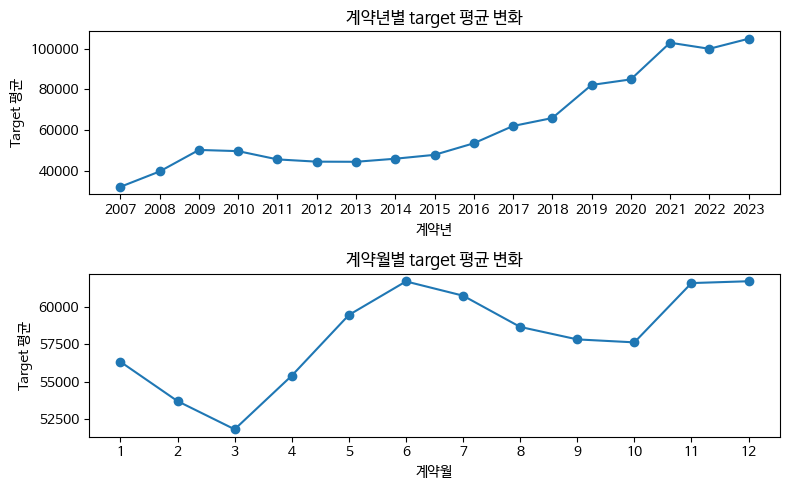

In [399]:
# df_year_month = pd.to_datetime(df['계약년월'], format='%Y%m')
# monthly_target_year_month = df.groupby(df_year_month.dt.to_period('M'))['target'].mean()

df_year = pd.to_datetime(df['계약년'], format='%Y')
monthly_target_year = df.groupby(df_year.dt.year)['target'].mean()

df_month = pd.to_datetime(df['계약월'], format='%m')
monthly_target_month = df.groupby(df_month.dt.month)['target'].mean()

plt.figure(figsize=(8, 5))

# plt.subplot(3, 1, 1)
# plt.plot(monthly_target_year_month.index.astype(str), monthly_target_year_month.values, marker='o')
# plt.title('계약년월별 target 평균 변화')
# plt.xlabel('계약년월')
# plt.ylabel('Target 평균')

plt.subplot(2, 1, 1)
plt.plot(monthly_target_year.index.astype(str), monthly_target_year.values, marker='o')
plt.title('계약년별 target 평균 변화')
plt.xlabel('계약년')
plt.ylabel('Target 평균')

plt.subplot(2, 1, 2)
plt.plot(monthly_target_month.index.astype(str), monthly_target_month.values, marker='o')
plt.title('계약월별 target 평균 변화')
plt.xlabel('계약월')
plt.ylabel('Target 평균')

plt.tight_layout()
plt.show()

# 계약일
 - 총 개수 : 1118822
 - 변수 타입 : 순서형
 - 결측치 : 없음
 - unique : 31, 한달 최대 31일이어서 그냥 쓰면 됨
 - Feature engineering : 계약년월과 합치는 방법도 있을 듯
 - Target과 상관관계 : 0.009로 거의 없음
 - 데이터 분포
    - 거래량 : 일별로 거의 비슷
    - 평균시세 : 점점 올라감

In [403]:
summaryBasicInfo('계약일', 5)

Data nums :  (1118822,)


Data values
20    40053
10    39165
15    39100
13    38198
18    37938
Name: 계약일, dtype: int64


Data missing nums :  0
Data unique nums :  31


In [411]:
getTargetCorr('계약일')

0.009348037386032505

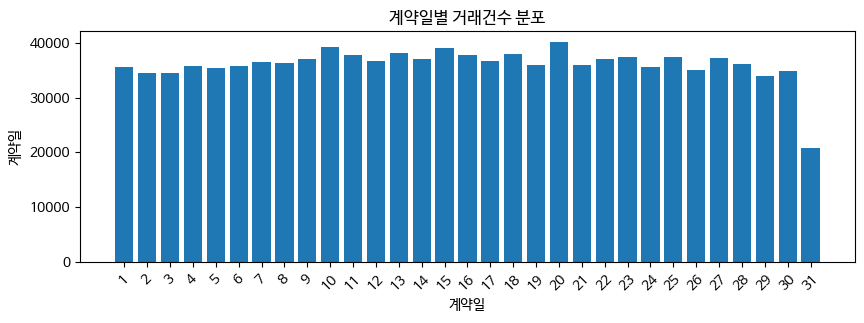

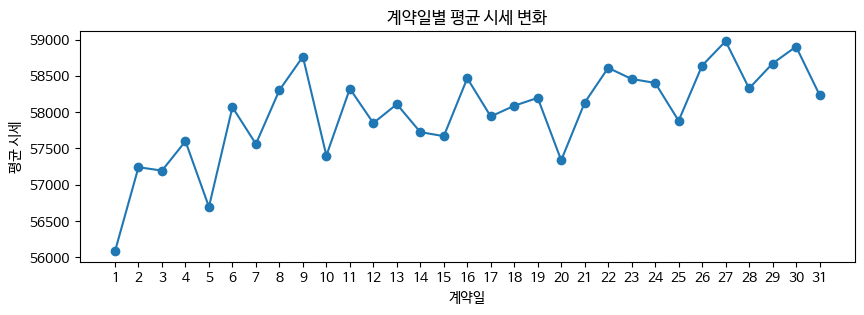

In [428]:
visualizeDistribution('계약일')

# 층
 - 층 개수 : 1118822
 - 변수 타입 : 순서형
 - 결측치 : 없음
 - unique : 73개
 - Feature engineering : 
 - Target과 상관관계 : 0.153, 상관관계 거의 없음
 - 데이터 분포
    - 1층~15층까지 거래수가 몰려있음
    - 층이 올라갈 수록 가격 상승, -2층에서 평균 가격 높은 현상

In [407]:
summaryBasicInfo('층', 5)

Data nums :  (1118822,)


Data values
5    82188
4    82045
3    80561
2    77037
6    73616
Name: 층, dtype: int64


Data missing nums :  0
Data unique nums :  73


In [408]:
getTargetCorr('층')

0.15317571715386719

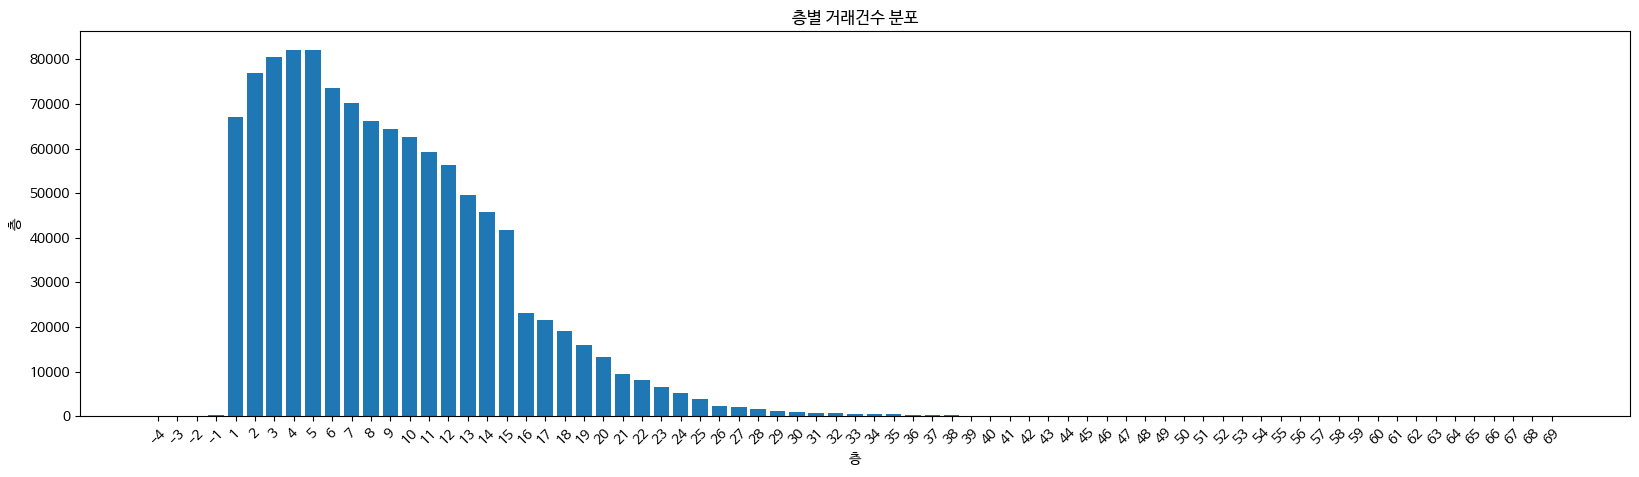

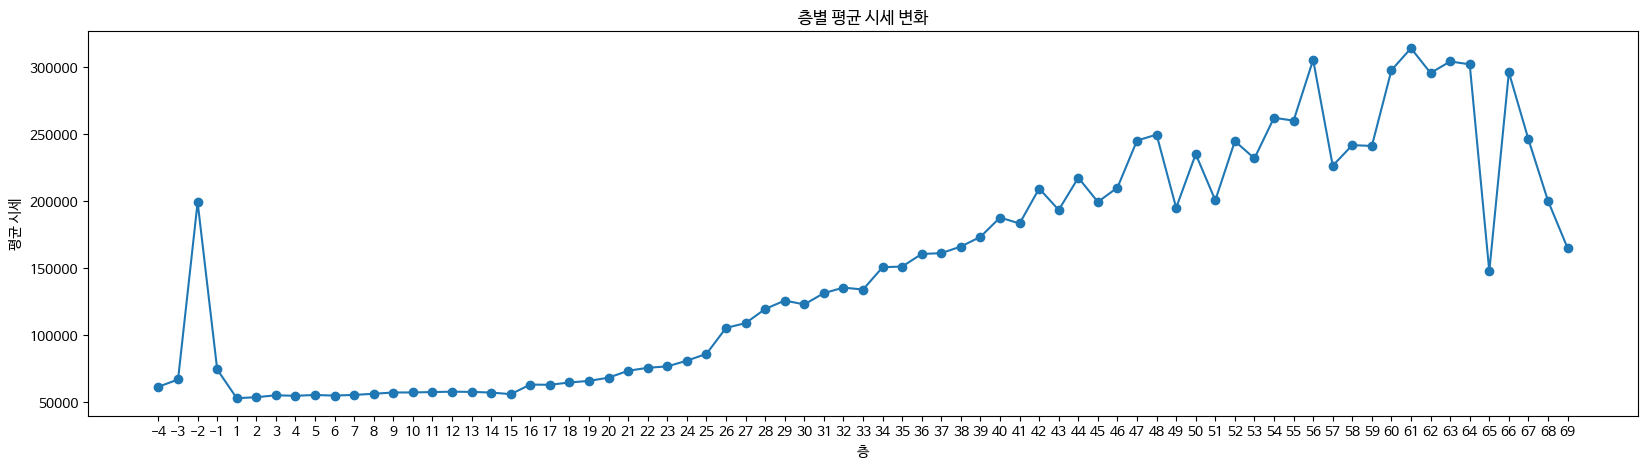

In [426]:
visualizeDistribution('층', (20, 5))

# 건축년도
 - 건축년도 개수 : 1118822
 - 변수 타입 : 순서형
 - 결측치 : 없음
 - unique : 60개
 - Feature engineering : baseline에서는 건축년도에 따라 신축인지 구축인지 파생변수 생성
 - Target과 상관관계 : 0.056, 상관관계 거의 없음
 - 데이터 분포
    - 건축년도별 거래수는 정규분포를 보임
    - 건축년도별 평균 거래 가격은 거의 안변하는 모습, 오히려 구축이 비싸보이는 현상

In [430]:
summaryBasicInfo('건축년도', 5)

Data nums :  (1118822,)


Data values
2004    68487
2003    65601
1999    59802
2000    56851
1988    55581
Name: 건축년도, dtype: int64


Data missing nums :  0
Data unique nums :  60


In [431]:
getTargetCorr('건축년도')

0.056040972001284516

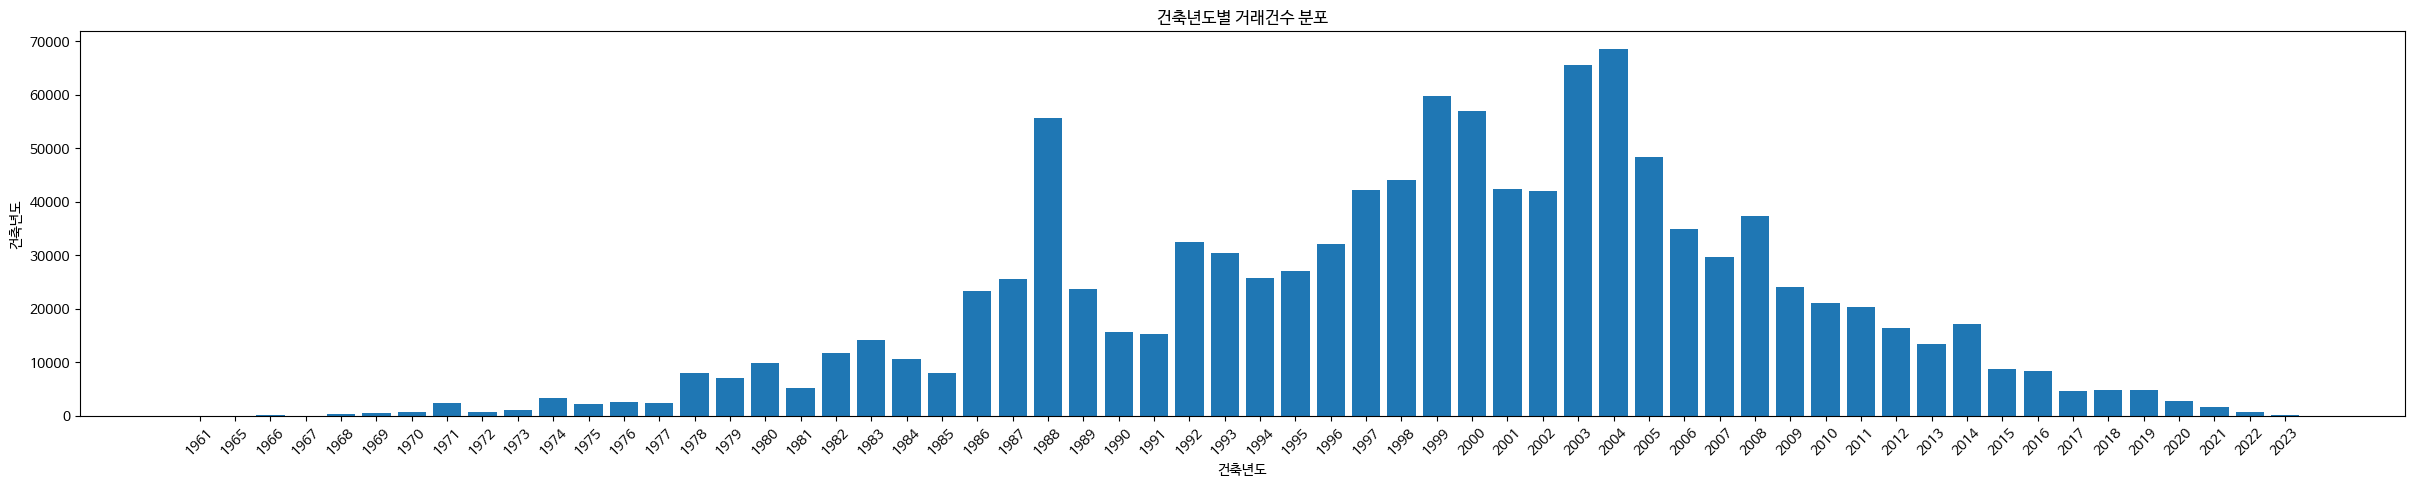

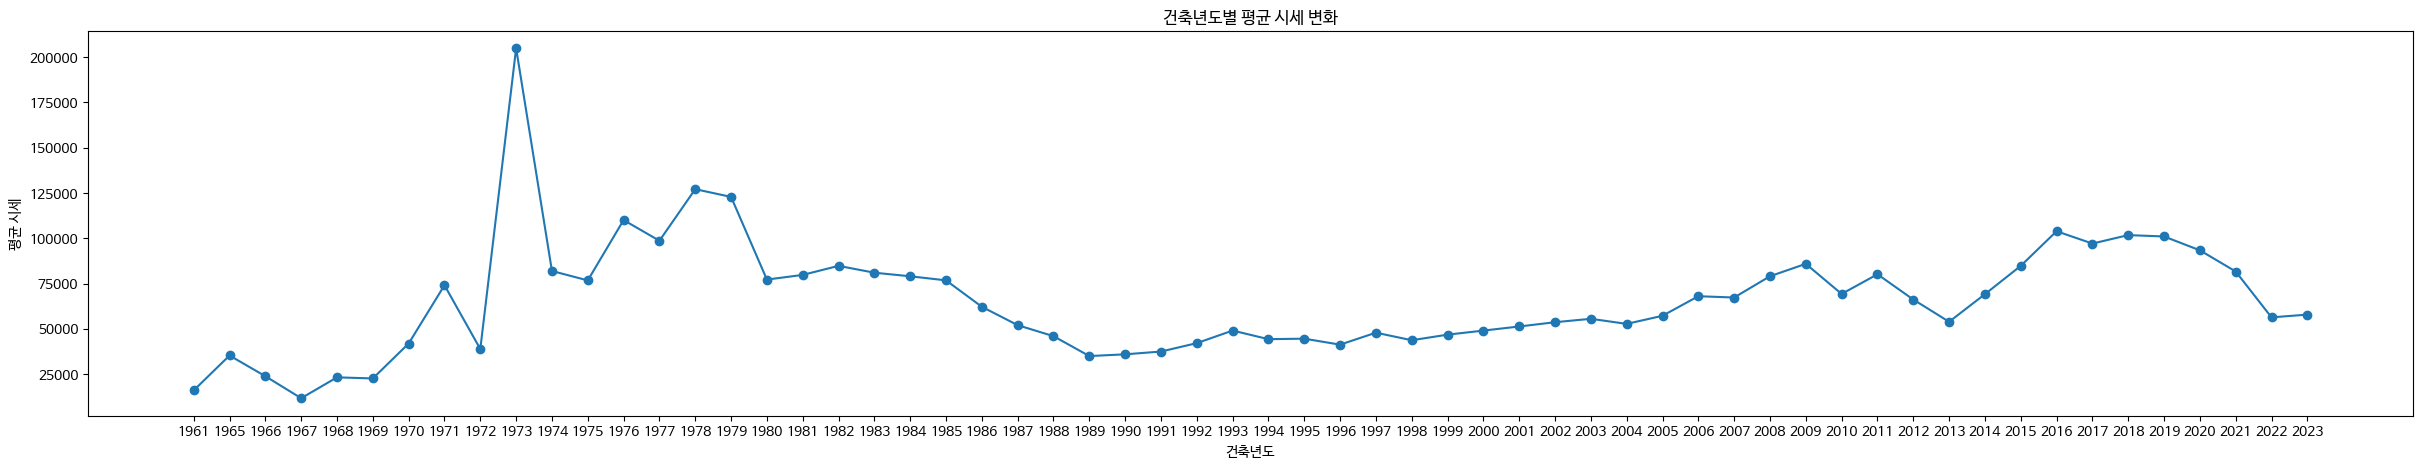

In [434]:
visualizeDistribution('건축년도', (30, 5))

# k-건설사 (시공사)

- **결측치**
    - 없음

- **데이터 분포**
    - Long-tail (상위 소수 건설사 + 다수의 희귀 건설사 존재)

- **데이터 종류**
    - 범주형 - 명목형 (Categorical - Nominal)
    - Encoding 방식: Label Encoding 또는 Target Encoding (Baseline은 Label Encoding)

In [182]:
feature_name = 'k-건설사(시공사)'

## Rare Category 조사

### Rare Category 정의

- 전체 데이터에서 등장 빈도가 매우 낮은 범주형 값(카테고리)을 의미함
- 일반적으로 전체 데이터의 **1% 이하** 또는 **건수 기준으로 극히 적은 값**을 Rare Category로 정의

### 검정
- 빈도(건수) 기준 검정 : 특정 카데고리의 등장 횟수가 기준 이하면 Rare로 간주
- 비율(%) 기준 검정 : 전체 데이터 대비 카테고리 비율이 일정 % 이하면 Rare로 간주

### 조사 목적

- 모델 학습 시 데이터가 적으면 해당 카테고리를 거의 학습하지 않음
- 테스트 데이터에서 처음 보는 Unseen 데이터 발생 가능성 대응
- 희귀 카테고리에 대한 과적합(Overfitting) 위험성 방지
- Drift + 희귀값 조합으로 인한 일반화 성능 저하 방지

### 처리 방식

- 기타 그룹(Rare)으로 통합
- Unknown으로 처리
- Target smoothing 등의 방법으로 적절하게 처리

### 그래프 시각화

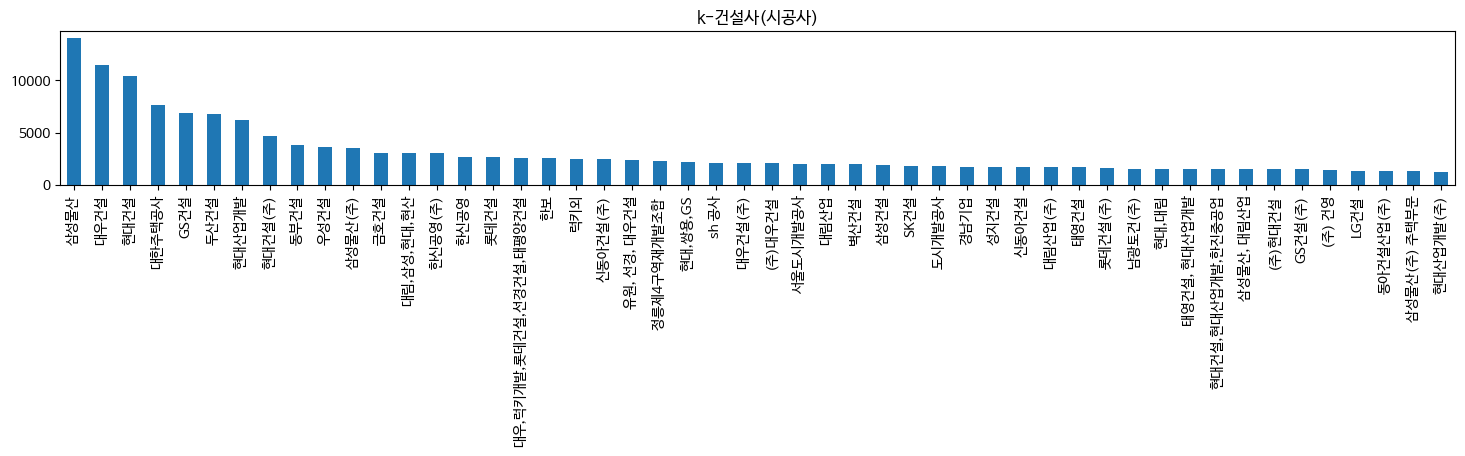

In [114]:
fig = plt.figure(figsize=(18, 2))
df[feature_name].value_counts().head(50).plot(kind='bar')
plt.title(feature_name)
plt.show()

### 최빈값 및 Cardinality

In [181]:
mode_value = df[feature_name].mode()[0]
mode_count = (df[feature_name] == mode_value).sum()
total_count = len(df[feature_name])
mode_ratio = (mode_count / total_count) * 100.0
print(f"최빈값 : {mode_value}, {mode_count}, {mode_ratio:.2f}%")
print(f"Cardinality : {df[feature_name].nunique()}")

최빈값 : 삼성물산, 14081, 1.26%
Cardinality : 344


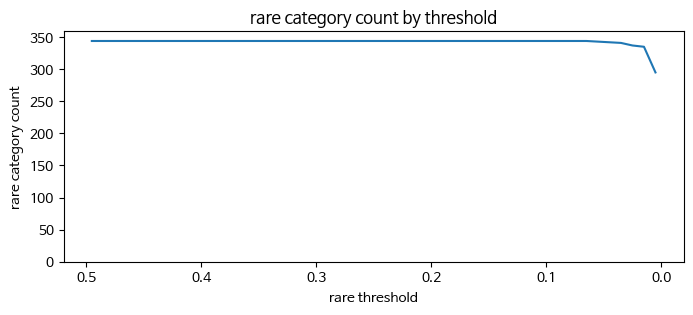

In [155]:
value_ratios = df[feature_name].value_counts(normalize=True)

rare_thresholds = [t for t in np.arange(0.005, 0.5, 0.01)]
rare_counts = []

for t in rare_thresholds:
    rare_categories = value_ratios[value_ratios <= t].index.tolist()
    rare_counts.append(len(rare_categories))

plt.figure(figsize=(8, 3))
plt.plot(rare_thresholds, rare_counts)
plt.ylim(0, 360)
plt.xlabel('rare threshold')
plt.ylabel('rare category count')
plt.title('rare category count by threshold')
plt.gca().invert_xaxis()
plt.show()

## Data Drift 조사
### Data Drift 정의
 - 학습 데이터와 실제 예측 대상(테스트 데이터)간에 **데이터 분포가 달라지는 현상**을 의미

 - 모델이 학습한 패턴과 테스트 데이터의 패턴이 달라저 **일반화 성능 저하**를 초래할 수 있음
### 검정 방법
 - **분포 시각화**
    - 학습 데이터와 테스트 데이터의 카테고리 비율을 Bar Chart 등으로 비교
    - 차이가 큰 경우 Drift 가능성

 - **카이제곱 검정 (Chi-squared Test)**
    - 범주형 데이터 분포의 통계적 차이 여부 검정
    - p-value < 0.05 유의미한 차이 -> Drift 판단

 - PSI (Population Stability Index)
    - 두 데이터 분포 간의 차이를 정량적으로 측정
    - PSI >= 0.25 -> 심각한 Drift 판단

 - 수치형 데이터의 경우 KS-Test, KL Divergence

### 조사 목적
 - 모델 성능 저하 방지 : Drift 발생시 예측 오류와 성능 저하를 막기 위함

 - 일반화 성능 유지 : Drift를 관리하여 모델이 특정 시점이나 환경에만 최적화되지 않도록 함

 - 데이터 품질 및 수집 프로세스 검증 : Drift는 수집 오류나 환경 변화의 신호일 수 있음 -> 데이터 품질 검토

 - 모델 재학습 필요성 판단 : Drift 정도에 따라 재학습 및 모델 업데이트 결정 가능

 - Unseen 데이터 문제 조기 인지 : 학습 데이터에 없던 신규 데이터 조기 감지 필요

### 처리 방식
 - Drift 원인이 되는 데이터 수집 프로세스 개선

 - 희귀 카테고리 통합 또는 Unkown 처리

 - 모델 재학습 : Drift가 심각할 경우 최신 데이터를 반영하여 모델을 재학습

 - **Feature Engineering : Drift 영향을 덜 받는 Feature로 교체하거나 보완 (대기업 건설사, 중견, 중소 등으로 통합)**

### Train, Test set 시각화

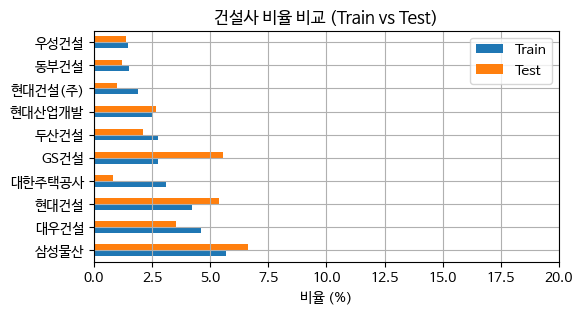

In [179]:
import pandas as pd
import matplotlib.pyplot as plt

# 예제 (여기에 train_df, test_df를 넣으세요)
train_ratio = df[feature_name].value_counts(normalize=True) * 100  # 퍼센트로 변환
test_ratio = df_test[feature_name].value_counts(normalize=True) * 100  # 퍼센트로 변환

# 합치기
df_compare = pd.concat([train_ratio, test_ratio], axis=1, keys=['Train', 'Test']).fillna(0)

# 상위 20개만
df_compare = df_compare.head(10)

# Plot
df_compare.plot(kind='barh', figsize=(6, 3))
plt.title('건설사 비율 비교 (Train vs Test)')
plt.xlabel('비율 (%)')
plt.xlim(0, 20)
plt.grid(True)
plt.show()

### Chi-squared test (카이제곱 검정)

In [180]:
from scipy.stats import chi2_contingency
import pandas as pd

# 예제 데이터 준비
train_counts = df[feature_name].value_counts()
test_counts = df_test[feature_name].value_counts()

df_concat = pd.concat([train_counts, test_counts], axis=1, keys=['train', 'test']).fillna(0)

# 카이제곱 검정
chi2, p, _, _ = chi2_contingency(df_concat)

print(f"p-value: {p}")

if p < 0.05:
    print("Drift 발생 가능성 있음 (유의 수준 5%)")
else:
    print("Drift 발생 가능성 낮음")

p-value: 0.0
Drift 발생 가능성 있음 (유의 수준 5%)


## Target Correlation 조사

### Target Correlation 정의

 - 범주형 Feature의 각 카테고리 값과 Target (예측 대상) 간의 **관계(연관성)**을 의미함
 - 특정 카테고리 값일 때 Target 값이 달라지는지 여부
 - 카테고리별 평균 Target값이 다르면 -> Target Correlation이 존재한다고 판단
    - 삼성 물산 : 평균 10억, 현대 건설 : 평균 3억, 중소 : 1억 => 평균 Target 값이 다르므로 Correlation 존재


### 데이터 분석 결과
- **데이터 통계**
    - 최빈값: 삼성물산, 14081, 1.26%
    - Cardinality: 344
    - Rare Category: rare threshold 비율을 0.005까지 낮춰도 약 300개 존재

- **데이터 분석**
    - 테스트 데이터에서 **Unseen 데이터** 발생 가능성
    - 거의 대부분의 Category가 희귀함
    - **최빈값(Bias)** 발생 시 모델이 상위 건설사에 편향될 가능성
    - 시간적 / 공간적 Drift
- **데이터 처리**
    - Feature Engineering : Drift 영향을 덜 받는 Feature로 교체하거나 보완 (대기업 건설사, 중견, 중소 등으로 통합)**